Advanced lane finding
=====================

> The goals / steps of this project are the following: 
> * Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
> * Apply a distortion correction to raw images.
> * Use color transforms, gradients, etc., to create a thresholded binary image.
> * Apply a perspective transform to rectify binary image ("birds-eye view").
> * Detect lane pixels and fit to find the lane boundary.
> * Determine the curvature of the lane and vehicle position with respect to center.
> * Warp the detected lane boundaries back onto the original image.
> * Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

Prereqs:
1. Calibrate camera

Pipeline per image:
1. Correct for distortion (using calibration results)
1. Binarize lane lines
1. Perspective transform to birds-eye
1. Fit polynomials to left and right lane
1. Calculate radius of each polynomial (in meters, not pixels)
1. Calculate position of vehicle with respect to center
1. Plot results on original image

Pipeline, video:
1. Run on image, save state
1. Repeat






In [75]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import cv2
import numpy as np

from lib.camera_calib import Undistorter
from lib.pipeline import binarize_lane_line_pixels, BirdsEyeTansformer
from lib.line import Line, LineType

%matplotlib inline

In [77]:
PATH_CAM_CALIBRATION_IMAGES = Path("./camera_cal")
TEST_IMAGES = sorted(Path("./test_images").glob("*.jpg"))
IMG_SHAPE = (1280, 720)  # y, x

LANE_START_X_LEFT = 185
LANE_START_X_RIGHT = IMG_SHAPE[0] - 150
LANE_WIDTH = LANE_START_X_RIGHT - LANE_START_X_LEFT
X_MIDDLE = (LANE_START_X_LEFT + LANE_WIDTH // 2)

APEX_Y = 450
APEX_X_OFFSET_LEFT = 65  # Relative to middle of lane
APEX_X_OFFSET_RIGHT = 30

DST_X_OFFSET = 300
DST_X_LEFT = DST_X_OFFSET
DST_X_RIGHT = IMG_SHAPE[0] - DST_X_OFFSET

In [78]:
# Counter clockwise from topleft
LANE_AREA_SRC = np.array([
    (X_MIDDLE - APEX_X_OFFSET_LEFT, APEX_Y),
    (LANE_START_X_LEFT, IMG_SHAPE[1] - 1),
    (LANE_START_X_RIGHT, IMG_SHAPE[1] - 1),
    (X_MIDDLE + APEX_X_OFFSET_RIGHT, APEX_Y),
], dtype=np.float32)

LANE_AREA_DST = np.array([
    (DST_X_LEFT, 0),
    (DST_X_LEFT, IMG_SHAPE[1] - 1),
    (DST_X_RIGHT, IMG_SHAPE[1] - 1),
    (DST_X_RIGHT, 0),
], dtype=np.float32)


In [79]:
undist = Undistorter(IMG_SHAPE)
undist.calibrate(PATH_CAM_CALIBRATION_IMAGES)

bird_trans = BirdsEyeTansformer(LANE_AREA_SRC, LANE_AREA_DST)

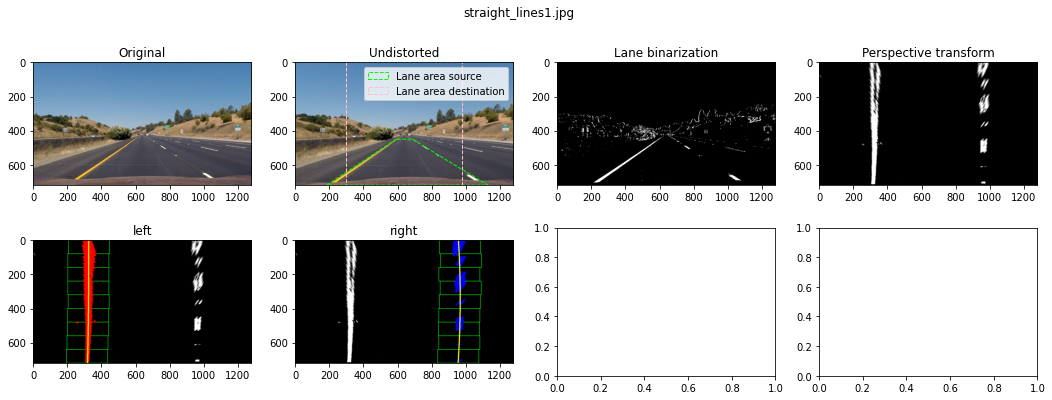

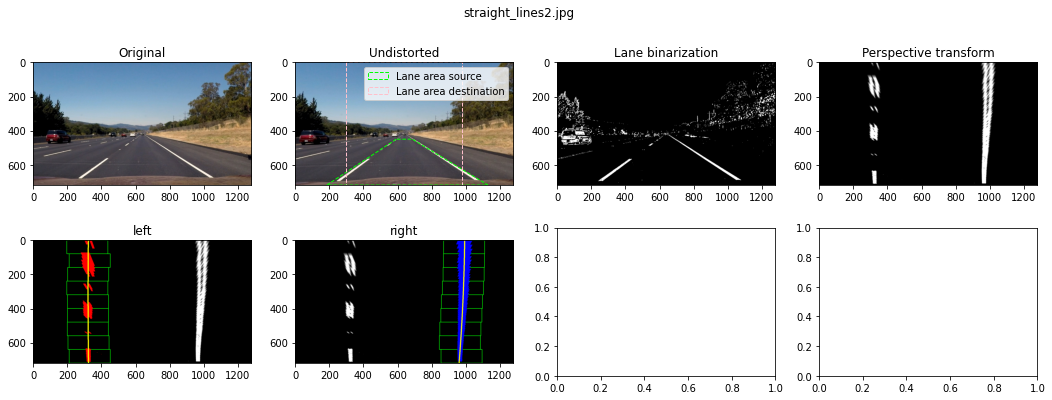

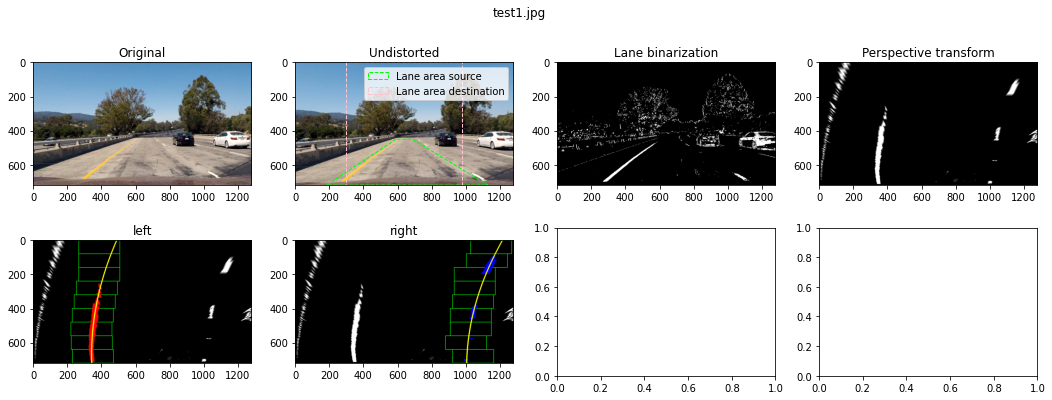

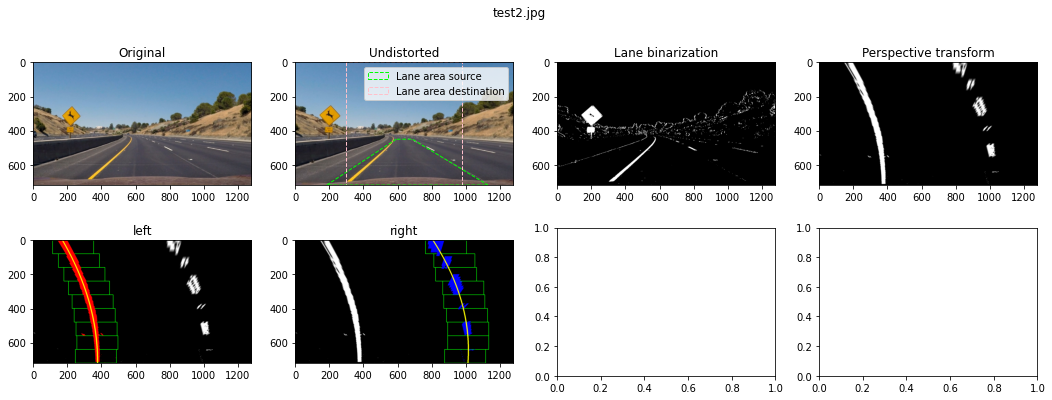

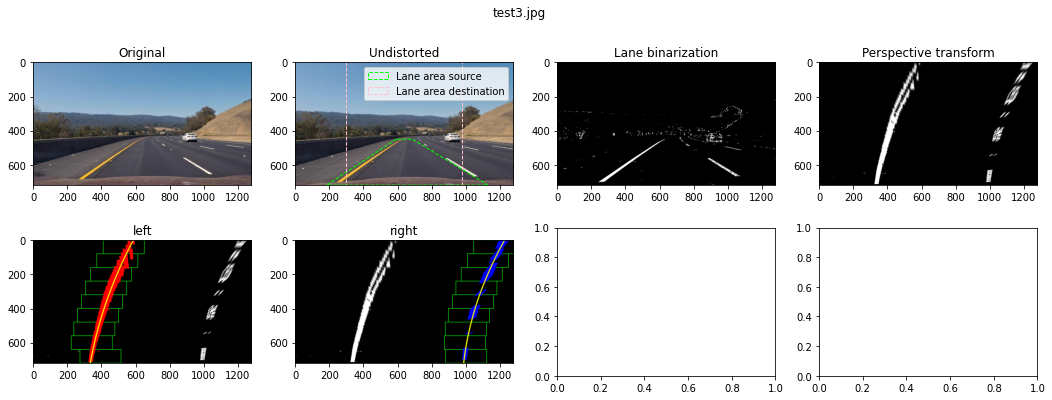

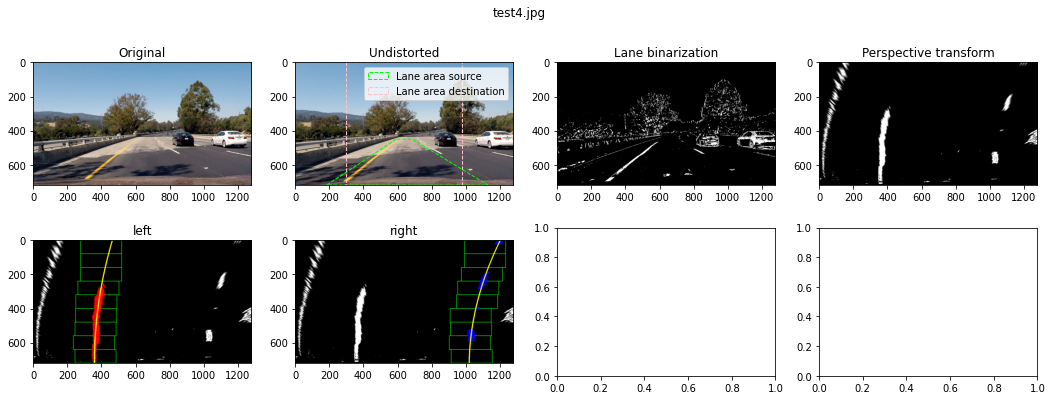

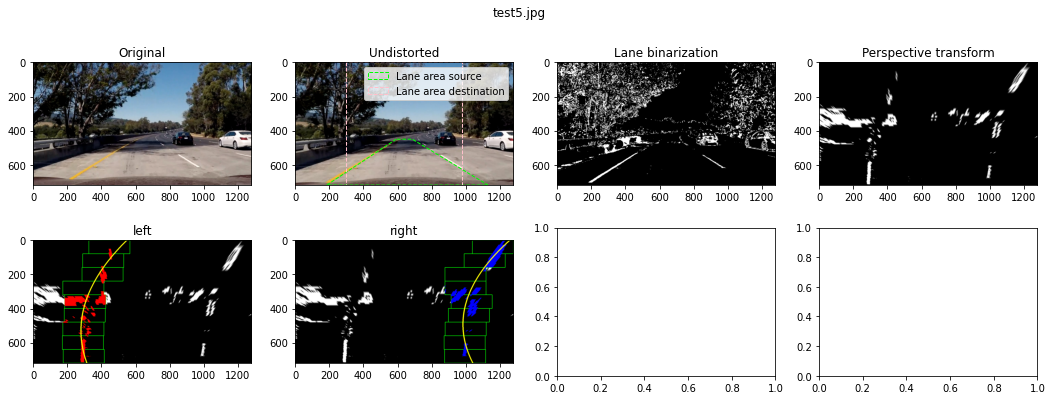

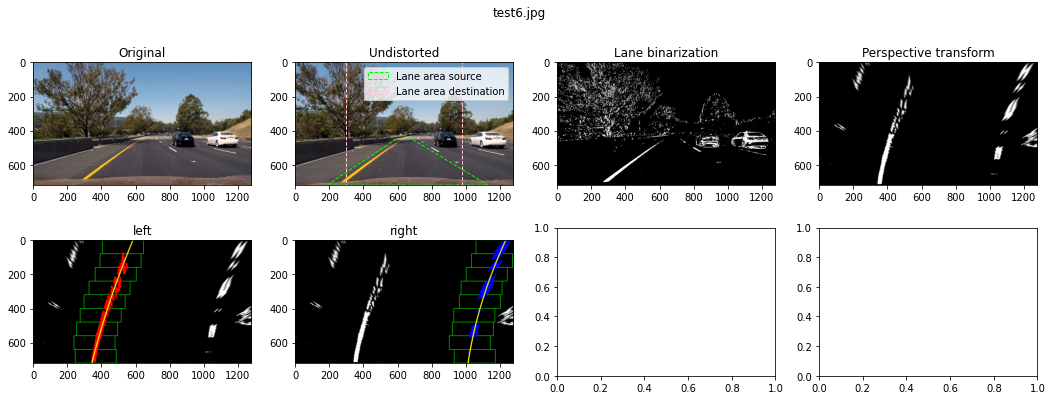

In [80]:
for img_path in TEST_IMAGES:
    _, ((l, ml, mr, r), (b1, b2, b3, b4)) = plt.subplots(nrows=2, ncols=4, figsize=(18, 6))
    img_dist = cv2.imread(str(img_path))
    
    img = undist.apply(img_dist)
    
    l.imshow(cv2.cvtColor(img_dist, cv2.COLOR_BGR2RGB))
    l.set_title("Original")
    
    ml.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ml.set_title("Undistorted")
    
    ml.add_patch(Polygon(LANE_AREA_SRC, linewidth=1, edgecolor="lime", facecolor="none", 
                        linestyle="--", label="Lane area source"))
    ml.add_patch(Polygon(LANE_AREA_DST, linewidth=1, edgecolor="pink", facecolor="none", 
                        linestyle="--", label="Lane area destination"))
    ml.legend()
    
    img_bin = binarize_lane_line_pixels(img, output_binary=True, s_thresh=(155, 255),  sx_thresh=(40, 140)) #s_thresh=(200, 255),  sx_thresh=(20, 100))
    cmap = "gray" if len(img_bin.shape) == 2 else None
    mr.imshow(img_bin, cmap=cmap)
    mr.set_title("Lane binarization")
    
    img_bird = bird_trans.apply(img_bin)
    r.imshow(img_bird, cmap=cmap)
    r.set_title("Perspective transform")

    for lt, ax in zip((LineType.LEFT, LineType.RIGHT), ((b1, b2))):
        l = Line.from_sliding_window(img_bird, lt)
        ax.imshow(l.sw_fit_viz)
        ax.set_title(LineType.to_str(lt))
        
    plt.suptitle(img_path.name)
    plt.show()

